In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
np.set_printoptions(suppress=True)

Using cuDNN version 7104 on context None
Mapped name None to device cuda0: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Helper function for visualization
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [29]:
# Load the data and process it.

df = pd.read_csv("mturk_surveys.csv.1")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

df = df[df['period'] < 45]

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')

In [30]:
data.head(10)

,min,max,count,count_history
0,0,0,1,897
1,0,1,2,56
2,0,2,2,54
3,0,2,3,8
4,0,3,2,44
5,0,3,3,13
6,0,3,4,2
7,0,4,2,25
8,0,4,3,17
9,0,4,4,2


In [31]:
# Summary of input

S = df['period'].max() + 1
V = len(workers)
freqs = data['count_history'].values
H = len(freqs)

print('Sampling periods:', S)
print('Unique patterns:', H)
print('Unique workers:', V)
print(min(df['date']), max(df['date']))

Sampling periods: 45
Unique patterns: 6049
Unique workers: 57250
2015-03-26 00:00:00 2018-12-04 00:00:00


In [32]:
# We want to see the survival marks to compute the total survival
# e.g, Arrive: 1, Depart: 2 => 011
# Dims: SxSxS
def make_survival(S):
    mask = np.zeros([S,S,S])  # arrival, departure, presence_sequence
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            mask[s,q]= np.concatenate((c1, c2, c3))
    return mask
survival = tt.constant(make_survival(S))

In [33]:
# A more compact way to represent all Arrival and departures from the data
# This is part of the input data, so we preprocess it!
def get_hmask(S, H, data):
    h_mask = np.zeros((H,S,S))
    for wh in np.arange(H):
        f, l = data['min'].values[wh] , data['max'].values[wh]
        h_mask[wh, :f+1, l:] = 1
    return h_mask
hmask = tt.constant(get_hmask(S, H, data))
hmask.shape

Shape.0

In [34]:
# For a given outcome in {1,S} (Frequency of capture that's not 0) 
# Generate the Binomial parameters n and i   choose(n, i)
# Nn is the duration from arrival to departure
# Ni is the Frequency we are intersted in
# Dim: SxSxS
def make_binmask(S, data):
    i = data['count'].values
    i = i[:, np.newaxis, np.newaxis] *  np.ones((H, S, S))
    n = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (H, S, S))
    return tt.constant(i), tt.constant(n)
Ni, Nn = make_binmask(S, data)
print('Tensor with number of captures', Ni.shape)
print('Tensor with durations from first to last seen', Nn.shape)

Tensor with number of captures Shape.0
Tensor with durations from first to last seen Shape.0


In [35]:
# Helper functions for the Beta Bernoulli Process
# TODO: switch to a single function even for the special case of 0 captures.

def get_BetaBi(a,b, S, Ni, Nn):
    # The beta binomial
    BBi  =  bound(betaln(Ni + a, Nn - Ni + b) - betaln(a, b),
                     Ni >= 0, Ni <= Nn,
                     a > 0, b > 0)
    # The above is the computation of the log, so we take the exponent
    return tt.exp(BBi)

def get_BetaB0(a, b, S):
    # The beta binomial for 0 captures
    Nn = tt.triu(tt.ones([S,S]), 0).cumsum(axis =1).eval()
    #B0 = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    B0 = bound(betaln(a, Nn + b) - betaln(a, b), 
               a > 0, b > 0)
    return tt.exp(B0)

In [36]:
def logp_capture(arrival_probs, departure_probs, a, b, U, survival_mask, Ni, Nn, S, V):
    def ll_capture_f(Nh, data_first_last_mask):
          
        # Likelihood of observing Li captures
        
        # compute the survival
        survival_prob = tt.pow(1 - departure_probs, survival_mask)
        survival_prob = tt.prod(survival_prob, axis=2)
        # compute the arrival and departure
        LAD      = arrival_probs[:, np.newaxis] * survival_prob * departure_probs    # SxS
        # keep only true possibilites
        True_LAD = LAD * data_first_last_mask # SxSxS
        
        # sum along the freqencies of catpures
        BetaBi  = get_BetaBi(a, b, S, Ni, Nn)
        Li      = tt.batched_tensordot(True_LAD, BetaBi, axes = 2) # S
        
        # Likelihood of No-Capture L0
        
        True_LAD0    = LAD * tt.triu(tt.ones((S,S)), 0)
        BetaB0   = get_BetaB0(a, b, S)
        L0       = tt.sum(True_LAD0 * BetaB0)
        
        # Multinomial
        obj1 = tt.gammaln(V + U + 1) - tt.gammaln(U + 1) - tt.sum(tt.gammaln(Nh+1))
        obj2 = tt.sum(Nh * tt.log(Li))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [37]:
# custom log-liklihood
# model

with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=1, upper=500000)
    ao = pm.Uniform('alpha', 0., 100)
    a = pm.Deterministic('alphaproxy', ao + 1)
    b = pm.Uniform('beta', 0., 100)

    phi = tt.zeros(S)
    phi_v    = pm.Uniform('departure', 0, .3, shape=S-1)
    phi = tt.set_subtensor(phi[S-1], 1.)
    phi = tt.set_subtensor(phi[:S-1],phi_v)
    
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    #U_print = tt.printing.Print('Unseen')(U)
    #a_print = tt.printing.Print('alpha')(a)
    #b_print = tt.printing.Print('beta')(b)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, survival, Ni, Nn, S, V), 
                        observed={'Nh': freqs ,
                                  'data_first_last_mask': hmask })

# ADVI Sampling

In [38]:
# "Super fast Sampling" using ADVI
with model:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    approx = inference.fit(n=20000)
    trace_vi = approx.sample(5000) 
    elbos1 = -inference.hist

Average Loss = 1.1153e+05: 100%|██████████| 20000/20000 [2:05:12<00:00,  2.66it/s]  
Finished [100%]: Average Loss = 1.1152e+05


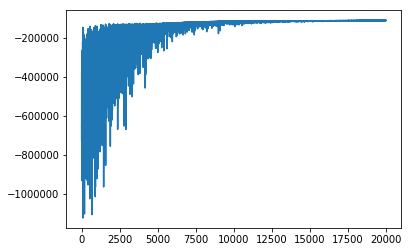

In [39]:
plt.plot(elbos1)

/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


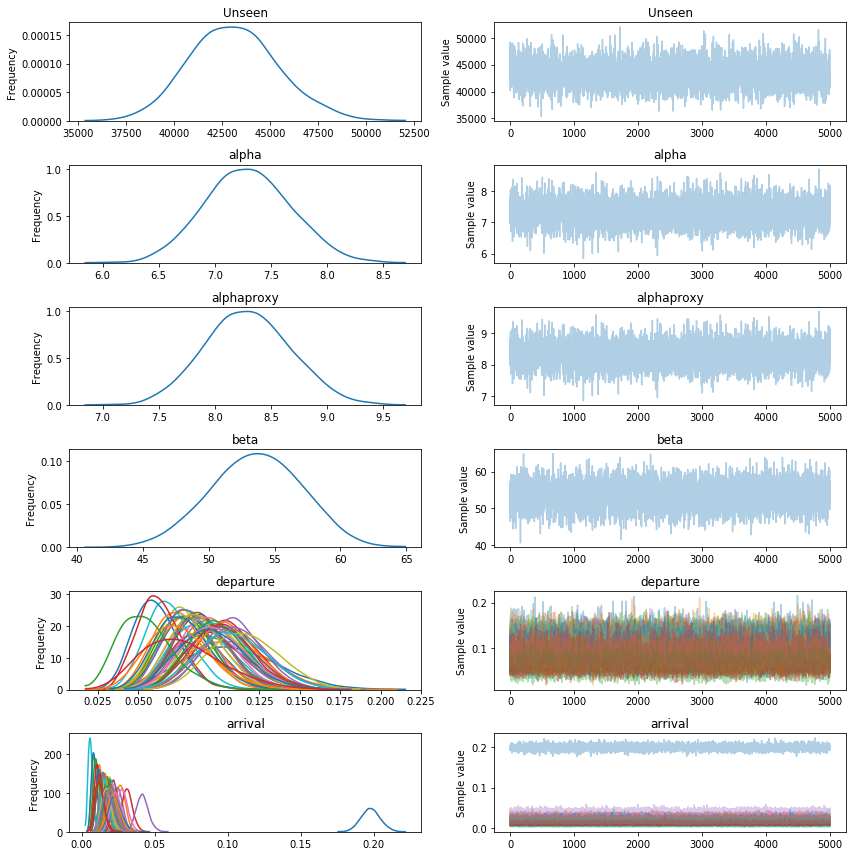

In [40]:
trace_vi = approx.sample(5000)
pm.traceplot(trace_vi);

In [41]:
pm.summary(trace_vi)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Unseen,43129.751259,2290.299162,29.557130,38795.482098,47783.963028
alpha,7.294773,0.381308,0.005044,6.522045,8.008657
alphaproxy,8.294773,0.381308,0.005044,7.522045,9.008657
beta,53.616468,3.437797,0.045230,47.041847,60.271891
departure__0,0.107740,0.028306,0.000353,0.054868,0.162367
departure__1,0.106626,0.024622,0.000366,0.060046,0.153569
departure__2,0.095964,0.022672,0.000297,0.053931,0.141581
departure__3,0.092774,0.020745,0.000252,0.052261,0.131589
departure__4,0.093627,0.020495,0.000265,0.056881,0.135022
departure__5,0.096102,0.019121,0.000256,0.059666,0.133182


<BarContainer object of 45 artists>

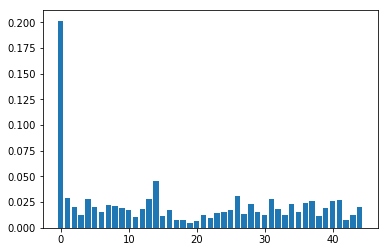

In [42]:
# Percentage of Super-population Arrivals
plt.bar(np.arange(S), trace_vi['arrival'][-1])

<BarContainer object of 44 artists>

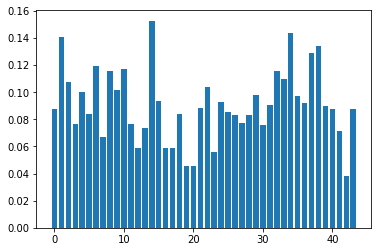

In [43]:
# Percentage of Departures
plt.bar(np.arange(S-1), trace_vi['departure'][-1])

# MCMC based Sampling

In [124]:
# Now we use precise sampling methods .. that take ages
with model:
  posterior = pm.sample(3000, tune = 1000, init = 'advi+adapt_diag',  chains = 1, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -1,882.5:   3%|▎         | 6326/200000 [01:44<53:09, 60.72it/s]
Interrupted at 6,331 [3%]: Average Loss = 11,026
Sequential sampling (1 chains in 1 job)
NUTS: [arrival, departure, beta, alpha, Unseen]
 40%|████      | 1610/4000 [07:32<11:12,  3.55it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
plot_traces(posterior, varnames = ['Unseen', 'alpha', 'beta']);

In [ ]:
pm.plot_posterior(posterior, varnames = ['Unseen', 'alpha', 'beta']);

In [ ]:
# Percentage of Super-population Arrivals
plt.bar(np.arange(S), posterior['arrival'][-1])

In [ ]:
# Percentage of Departures
plt.bar(np.arange(S-1), posterior['departure'][-1])

In [ ]:
pm.energyplot(posterior)